# Stage 2: Clustering documents
## Basic ideas: 
1. Use title, abstract to generate, select features
2. Do clustering

## init and input

In [451]:
import gensim
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import KernelPCA
from sklearn import manifold
from pattern.en.wordlist import BASIC
from pattern.en import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [4]:
fpaper = 'paper_dataset.txt'
dpaper = pd.read_csv(fpaper, sep='\t')
titles = np.array(dpaper['title'])
abstracts = np.array(dpaper['abstract'])
indices = np.array(dpaper['index_keys'])

## Preprocessing
Preprocessing consists of following parts: 
1. Remove punctuations
2. Tokenization
3. Remove stopwords
4. Lemmatize
5. Do above for all abstracts and titles. Construct new vector of words. 

In [331]:
stops = set(stopwords.words("english"))
lmtzr = WordNetLemmatizer()

def pre_processing_a_sentence(sentence, method):
    if method == 'BoW':
        # remove punctuations
        sentence_without_puncs = re.sub("[^a-zA-Z0-9]", " ", sentence)
        # Tokenization
        words_in_sentence = sentence_without_puncs.lower().split()
        # Remove stop words
        words_in_sentence = [w for w in words_in_sentence if not w in stops]
        ## Wordlists
        # words_in_sentence = [w for w in words_in_sentence if not w in BASIC]
        # Lemmatize
        words_lemmatized_in_sentence = []
        for w in words_in_sentence:
            w = lmtzr.lemmatize(w, pos = 'v')
            words_lemmatized_in_sentence.append(w)
    else:
        # remove punctuations
        sentence_without_puncs = re.sub("[^a-zA-Z0-9]", " ", sentence)
        # Tokenization
        words_in_sentence = sentence_without_puncs.lower()
        
        n2 = ngrams(words_in_sentence, n=2, punctuation=".,;:!?()[]{}`''\"@#$^&*+-|=~_", continuous=False)
        joined_n2=[]
        for phrase_words in n2:
            joined_n2.append('-'.join(phrase_words))
            
        n3 = ngrams(words_in_sentence, n=3, punctuation=".,;:!?()[]{}`''\"@#$^&*+-|=~_", continuous=False)
        joined_n3=[]
        for phrase_words in n3:
            joined_n3.append('-'.join(phrase_words))
            
        words_lemmatized_in_sentence = []
        words_lemmatized_in_sentence.extend(joined_n2)
        words_lemmatized_in_sentence.extend(joined_n3)
        
    return words_lemmatized_in_sentence

def pre_processing(sentence_array, method):
    num = sentence_array.size
    words_array_clean = []
    
    # delete "NaN" (if there's any)
    sentence_array_nan_indices = pd.isnull(sentence_array)
    for i in xrange( 0, num ):
        if(sentence_array_nan_indices[i] == False):
            words_array_clean.append( str(pre_processing_a_sentence( sentence_array[i], method ) ) )
        else:
            words_array_clean.append( ' ' )
            
    return words_array_clean

In [359]:
w_abstract = pre_processing(abstracts, 'ngrams')
w_title = pre_processing(titles, 'BoW')
w_index = pre_processing(indices, 'BoW')

## Feature generation

### Generate features using BoW/ngrams model with TF-IDF

In [406]:
vectorizer_abstract = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 10000) # 600*150=90000
vectorizer_title = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 1000) # 600*10 = 6000
vectorizer_index = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 1000) # 600*10 = 6000

def feature_generation(word_array, vectorizer):
    feature_array = vectorizer.fit_transform(word_array).toarray()
    feature_list = vectorizer.get_feature_names()
    return feature_array, feature_list

In [407]:
feature_array_title, feature_list_title = feature_generation(w_title, vectorizer_title)
feature_array_abstract, feature_list_abstract = feature_generation(w_abstract, vectorizer_abstract)
feature_array_index, feature_list_index = feature_generation(w_index, vectorizer_index)

### 1.PCA to extract import features
- Percentage of variance(eigenvalues of the covariance matrix of X) explained by each of the selected components.
- The singular values corresponding to each of the selected components. 

In [107]:
def PCA_analysis(feature_array, n):# find first n highest variances
    pca = PCA(n_components = n) 
    pca.fit(feature_array)
    feature_array_pca = pca.transform(feature_array)
    
    plt.figure(1)
    
    plt.subplot(211)
    plt.plot(pca.explained_variance_ratio_, 'ro')
    plt.ylabel('Percentage of variances')
    leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
    #leg.get_frame().set_alpha(0.5)
    
    plt.subplot(212)
    plt.plot(pca.singular_values_, 'bo')
    plt.ylabel('Singular values')
    leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
    #leg.get_frame().set_alpha(0.5)
    plt.show()
    
    return feature_array_pca

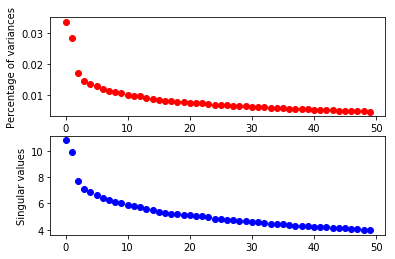

In [394]:
feature_array_title_pca = PCA_analysis(feature_array_title, 50)

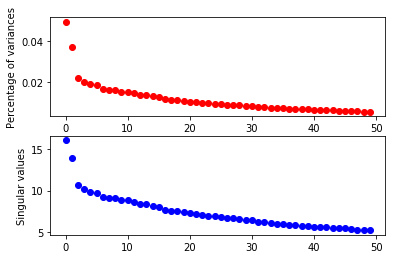

In [408]:
feature_array_index_pca = PCA_analysis(feature_array_index, 50)

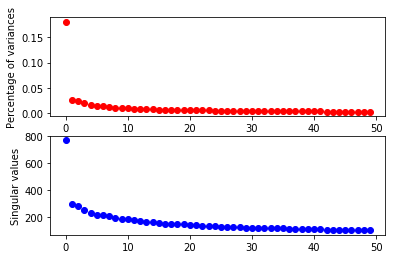

In [395]:
feature_array_abstract_pca = PCA_analysis(feature_array_abstract, 50)

### Evaluation of decompositions
Do some scatter plots. Use only the first 2/3 features to form a space. They are written in different functions. (How to visualize dimention more than 3?)

In [155]:
def scatter_visualization_2D(data_array):
    plt.scatter(data_array[:,0], data_array[:,1], c='red', s=10, label='Papers',
               alpha=0.3, edgecolors='none')
    plt.legend()
    plt.grid(True)
    plt.show()

In [156]:
def scatter_visualization_3D(data_array):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data_array[:,0], data_array[:,1], data_array[:,2], c='red', s=10, label='Papers',
               alpha=0.3, edgecolors='none')
    ax.legend()
    ax.grid(True)
    plt.show()

### Visualization

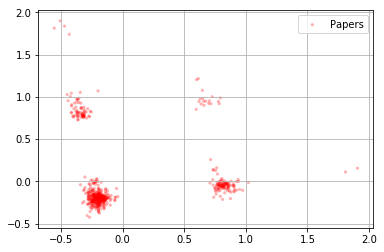

In [416]:
scatter_visualization_2D(feature_array_title_pca)

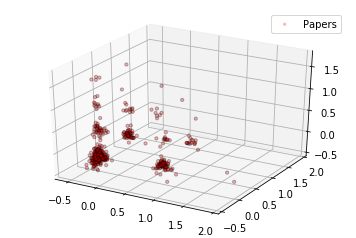

In [417]:
scatter_visualization_3D(feature_array_title_pca)

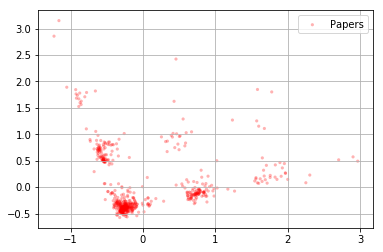

In [418]:
scatter_visualization_2D(feature_array_index_pca)

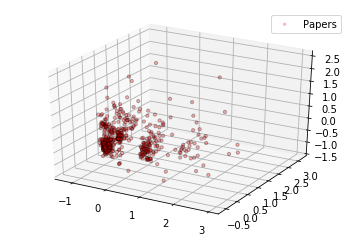

In [419]:
scatter_visualization_3D(feature_array_index_pca)

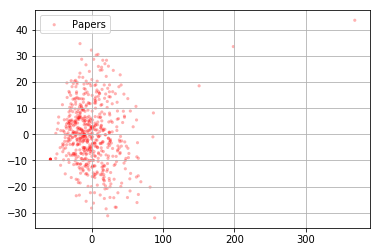

In [398]:
scatter_visualization_2D(feature_array_abstract_pca)

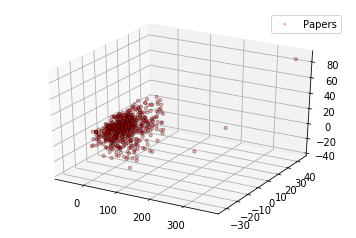

In [399]:
scatter_visualization_3D(feature_array_abstract_pca)

### PCA conclusions
From here we can conclude for PCA:
- 10 title features are suitable
- 20 abstract features are suitable

And we can also observe from percentage of variants plot that this value decreased to about 0.01 at around 10 for both title and abstracts. With respect to the fact that the abstract feature array is far longer than title feature array(90000 VS 6000), it shows the words in titles are more representative than the words in abstracts, which makes sense. 

From the scatter plot we can say that titles are indeed better. 

### 2. SVD dimentionality reduction

In [127]:
def SVD_analysis(feature_array, n):# find first n highest variances
    svd = TruncatedSVD(n_components = n, n_iter=7, random_state=47)
    svd.fit(feature_array)
    feature_array_svd = svd.transform(feature_array)
    
    plt.figure(1)
    
    plt.subplot(211)
    plt.plot(svd.explained_variance_ratio_, 'ro')
    plt.ylabel('Percentage of variances')
    leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
    #leg.get_frame().set_alpha(0.5)
    
    plt.subplot(212)
    plt.plot(svd.singular_values_, 'bo')
    plt.ylabel('Singular values')
    leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
    #leg.get_frame().set_alpha(0.5)
    plt.show()
    
    return feature_array_svd

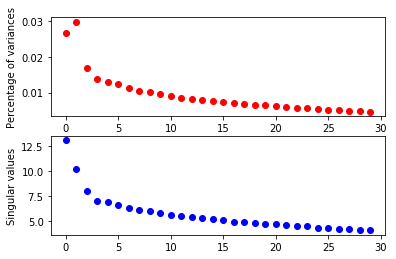

In [420]:
feature_array_title_svd = SVD_analysis(feature_array_title, 30)

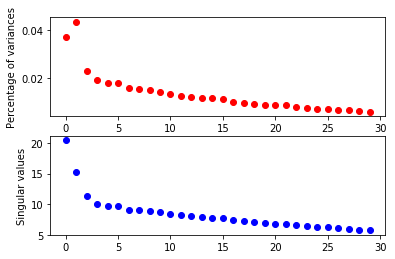

In [421]:
feature_array_index_svd = SVD_analysis(feature_array_index, 30)

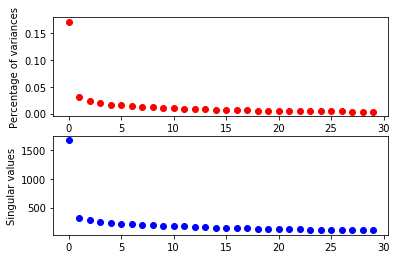

In [422]:
feature_array_abstract_svd = SVD_analysis(feature_array_abstract, 30)

### Evaluation of decompositions: visualization
Do same scatter plots as above PCA analysis. 

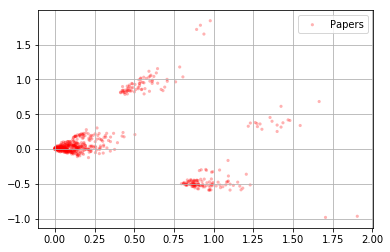

In [423]:
scatter_visualization_2D(feature_array_title_svd)

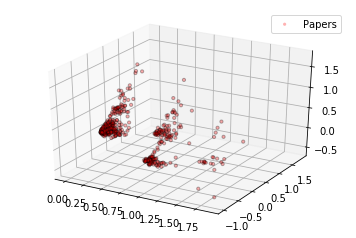

In [424]:
scatter_visualization_3D(feature_array_title_svd)

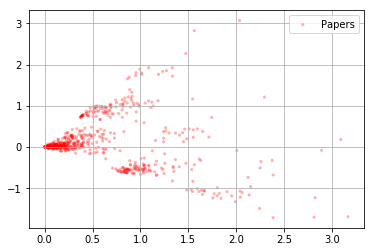

In [427]:
scatter_visualization_2D(feature_array_index_svd)

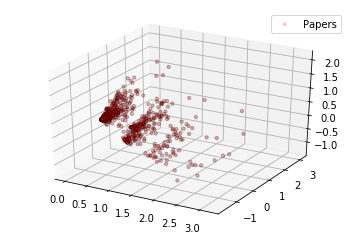

In [426]:
scatter_visualization_3D(feature_array_index_svd)

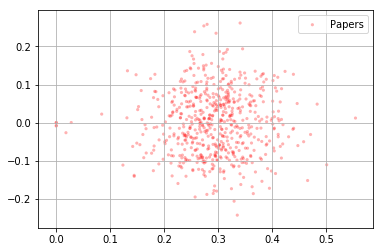

In [391]:
scatter_visualization_2D(feature_array_abstract_svd)

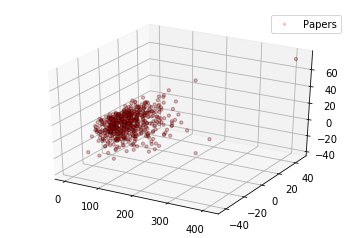

In [345]:
scatter_visualization_3D(feature_array_abstract_svd)

### SVD conclusions
We still decide to keep 10 for titles and 20 for abstracts. 
Need to do more for feature selection from abstracts. Or it's just because we can only see 3 dimentions. 
Obviously understanding the meanings of abstract is much harder than titles. 

### 3. Kernel PCA
As the results from abstracts are bad, trying kernel PCA on it. 

In [242]:
def kPCA_analysis(feature_array, n):# find first n highest variances
    kpca = KernelPCA(n_components = n, kernel="cosine", fit_inverse_transform=True, gamma=10)
    feature_array_kpca = kpca.fit_transform(feature_array)
    
    plt.figure(1)
    
    plt.subplot(111)
    plt.plot(kpca.lambdas_, 'ro')
    plt.ylabel('Eigenvalues of the centered kernel matrix')
    leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
    #leg.get_frame().set_alpha(0.5)
    
    plt.show()
    
    return feature_array_kpca

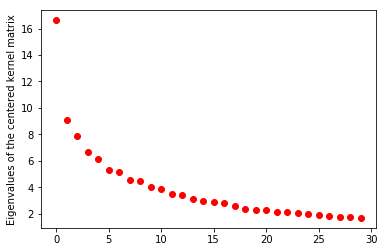

In [346]:
feature_array_abstract_kpca = kPCA_analysis(feature_array_abstract, 30)

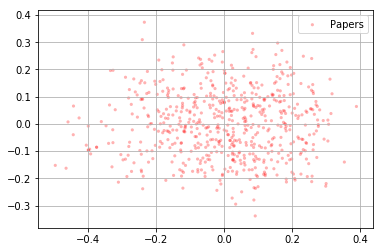

In [347]:
scatter_visualization_2D(feature_array_abstract_kpca)

### 4. LLE
Try a non-linear dimentional reduction

In [205]:
def LLE(feature_array, _n_neighbors, _n_components, method_number):
    methods = ['standard', 'ltsa', 'hessian', 'modified']
    labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']
    Y = manifold.LocallyLinearEmbedding(n_neighbors = _n_neighbors, n_components = _n_components,
                                    eigen_solver='auto',
                                    method=methods[method_number]).fit_transform(feature_array)
    return Y    

In [348]:
feature_array_abstract_LLE = LLE(feature_array_abstract, 20, 20, 1)

In [222]:
feature_array_abstract_LLE

array([[  5.25989911e-03,  -1.25117023e-02,  -1.05065895e-02, ...,
         -2.86377465e-03,  -3.88923625e-04,   2.09291446e-03],
       [  9.02056208e-17,   1.66533454e-16,   1.38777878e-17, ...,
          2.77555756e-17,   1.04083409e-17,  -5.55111512e-17],
       [ -4.54370001e-03,  -1.08514325e-02,   3.78258081e-02, ...,
         -1.26526343e-02,   5.46770316e-03,   1.86087046e-02],
       ..., 
       [ -6.03448177e-03,   1.13938939e-03,   3.12622367e-03, ...,
         -1.96500981e-03,  -1.30126959e-03,   2.40146657e-03],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  4.31744139e-02,   1.68258772e-01,  -7.15294862e-02, ...,
          1.87704910e-02,  -1.03393942e-01,   1.36584882e-01]])

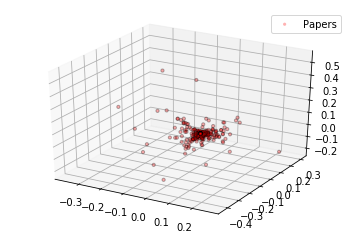

In [246]:
scatter_visualization_3D(feature_array_abstract_LLE)

### Final decision on feature selection
Still can't find a way to select good features from abstract. So gonna use title and index. 
- feature_array_title_pca
- feature_array_index_pca

## Clustering
Try to types of clustering:
- k-means
- DBSCAN

### k-means

In [485]:
def kmeans_cluster(features, k):
    kmeans = KMeans(n_clusters =k, random_state = 0).fit(features)
    return kmeans.labels_, kmeans.cluster_centers_

In [460]:
def find_k(features):
    for k in range(5,20):
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(features) + (k + 1) * 10])
        
        kmeans = KMeans(n_clusters =k, random_state = 0).fit(features)
        klabels = kmeans.labels_
        silhouette_avg = silhouette_score(features, klabels)
        sample_silhouette_values = silhouette_samples(features, klabels)
        y_lower = 10
        for i in range(k):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[klabels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / k)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(klabels.astype(float) / k)
        ax2.scatter(features[:, 0], features[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = kmeans.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % k),
                     fontsize=14, fontweight='bold')

        plt.show()


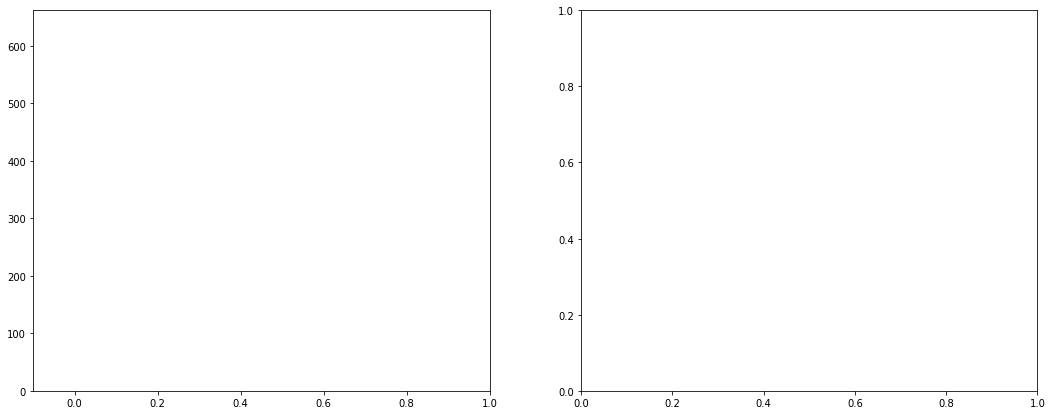

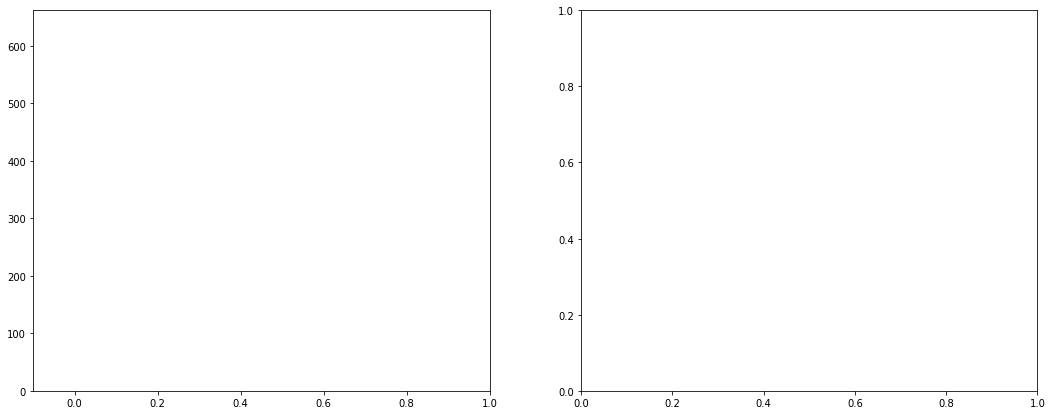

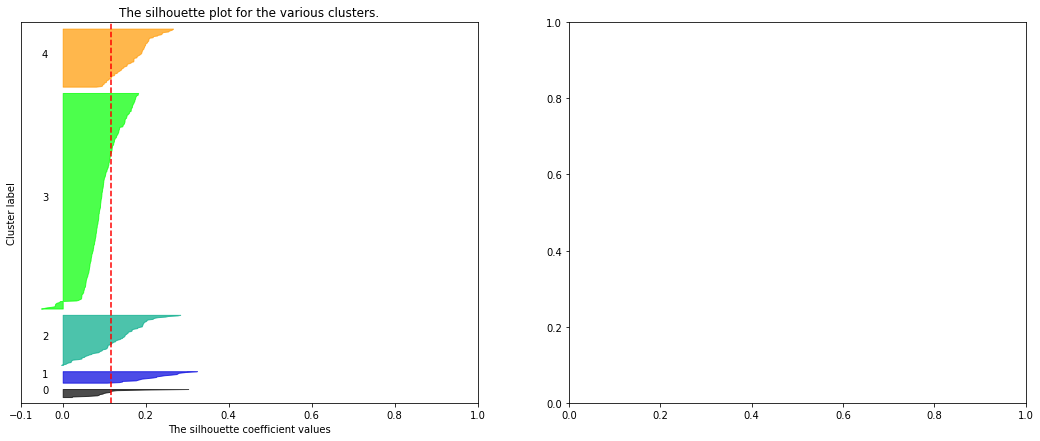

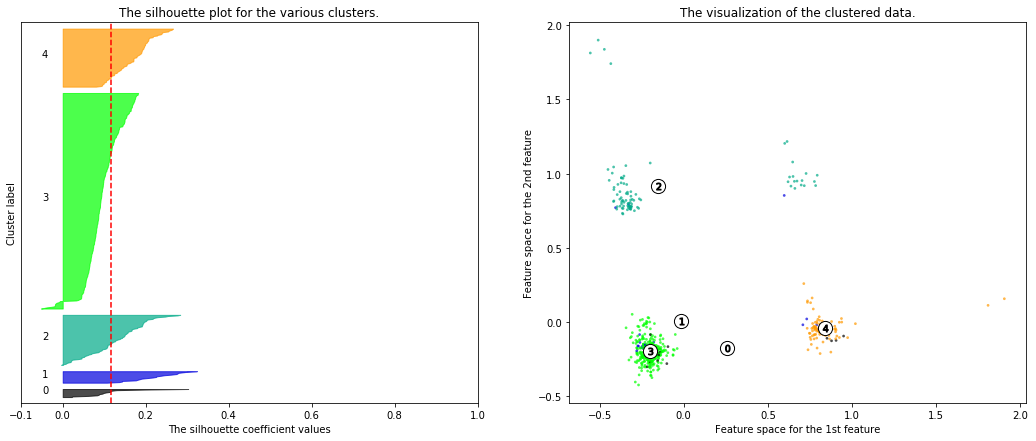

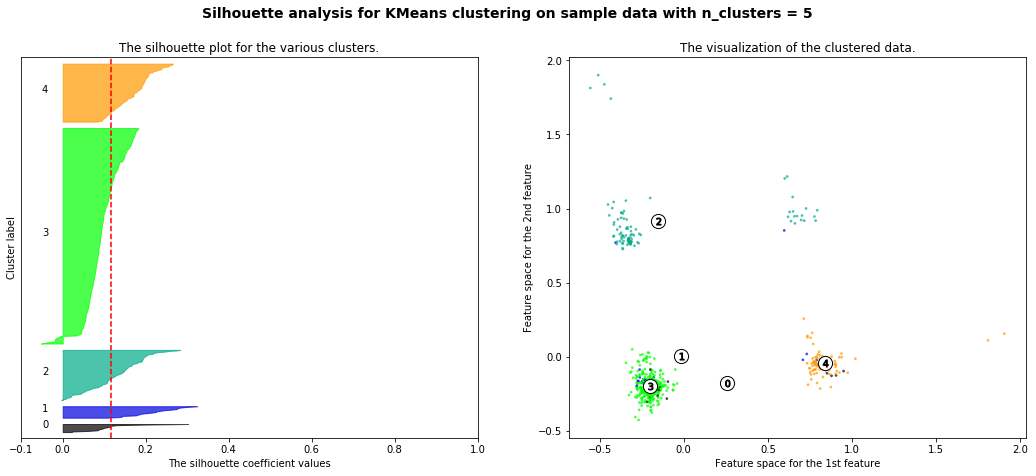

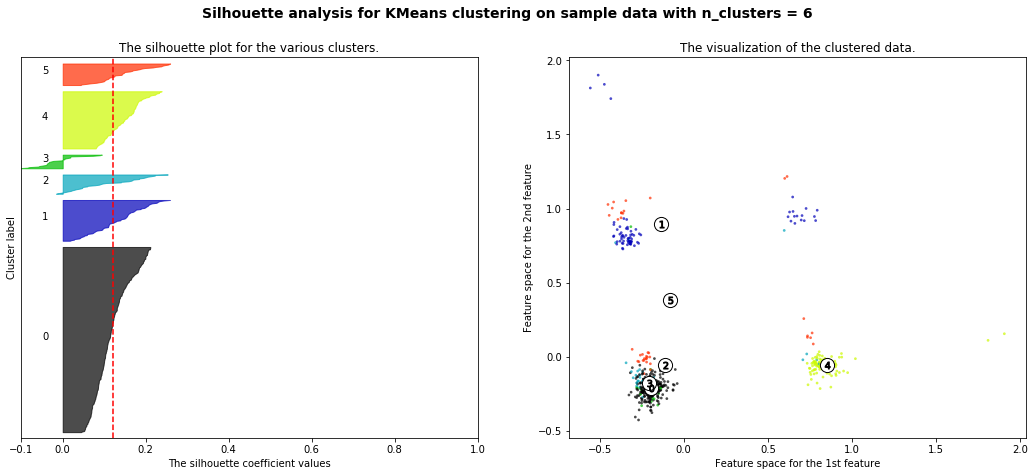

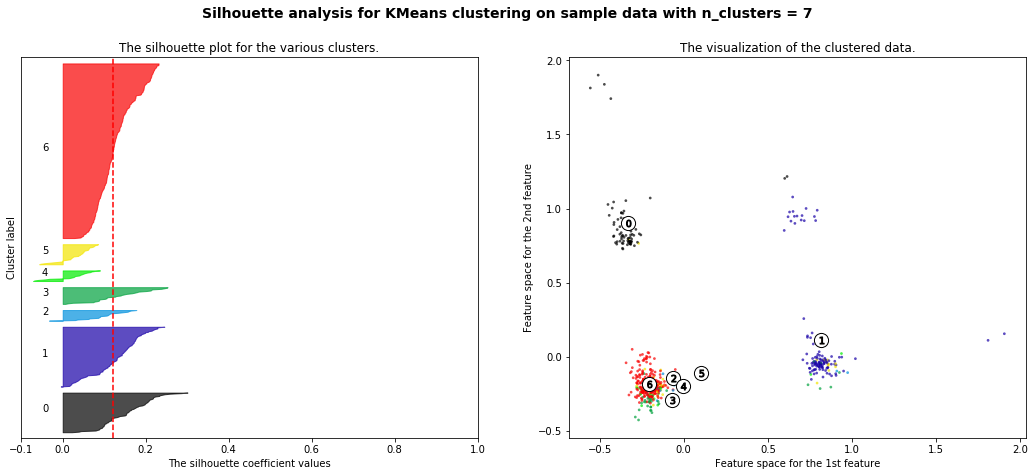

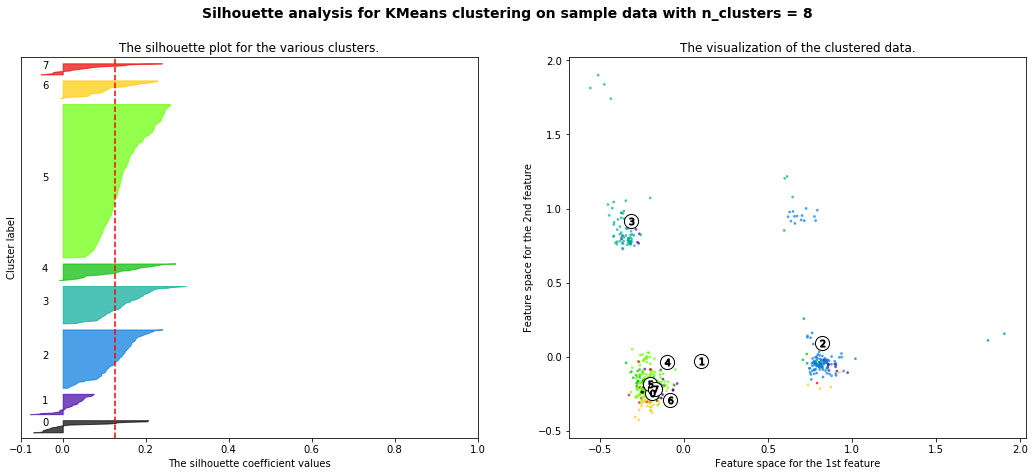

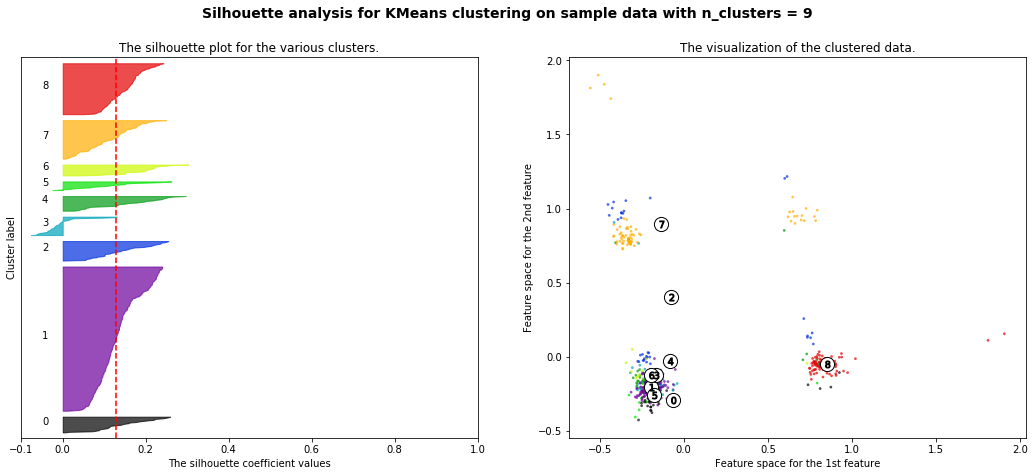

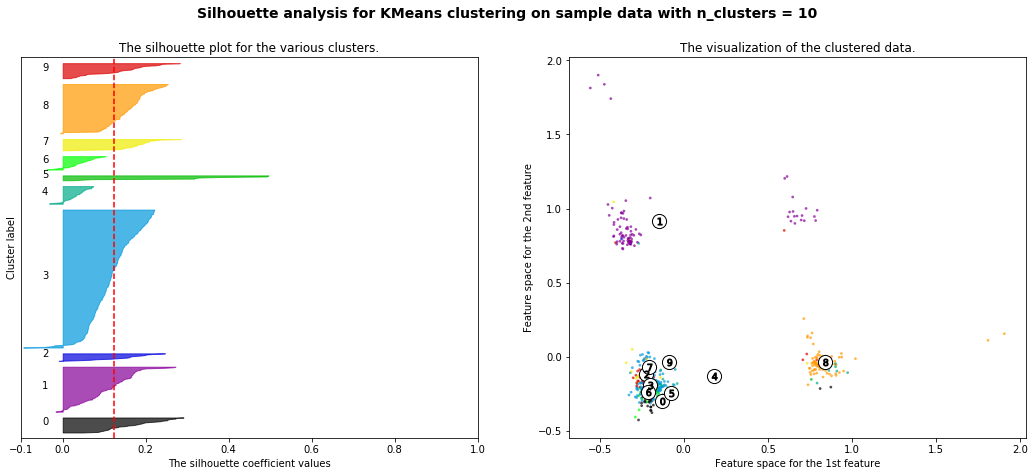

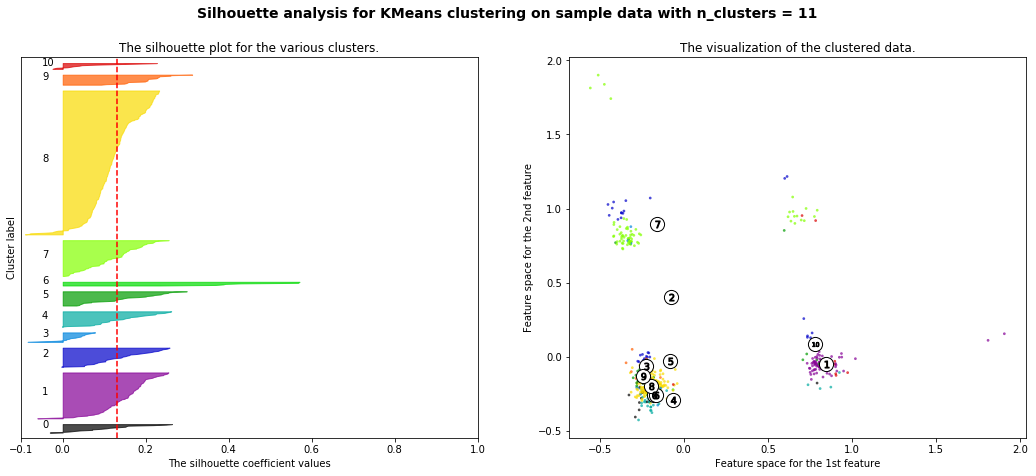

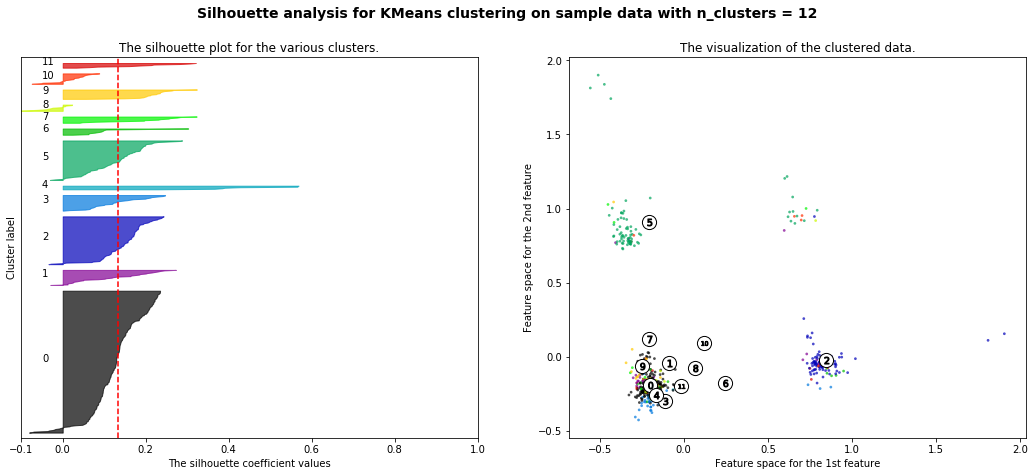

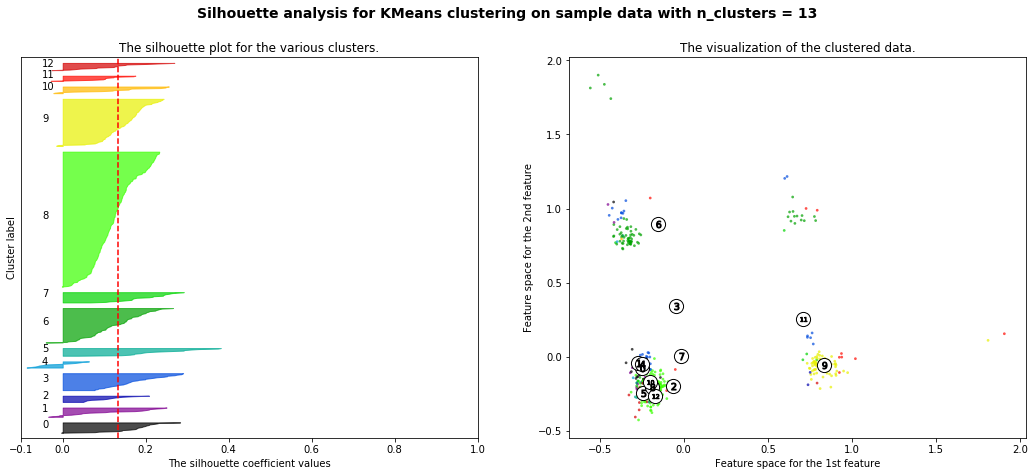

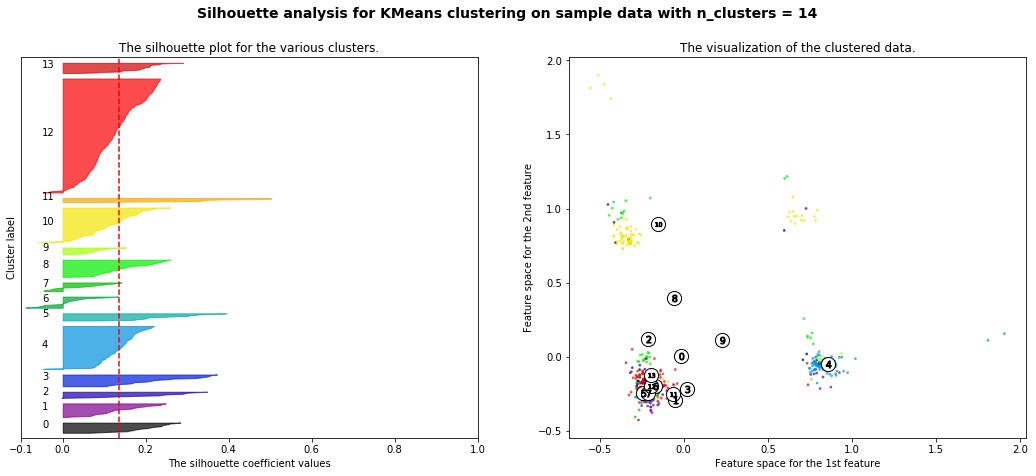

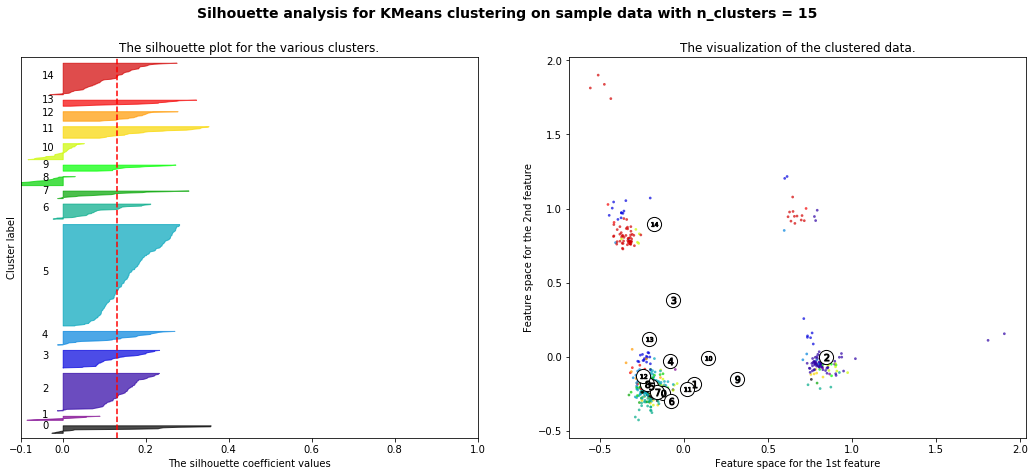

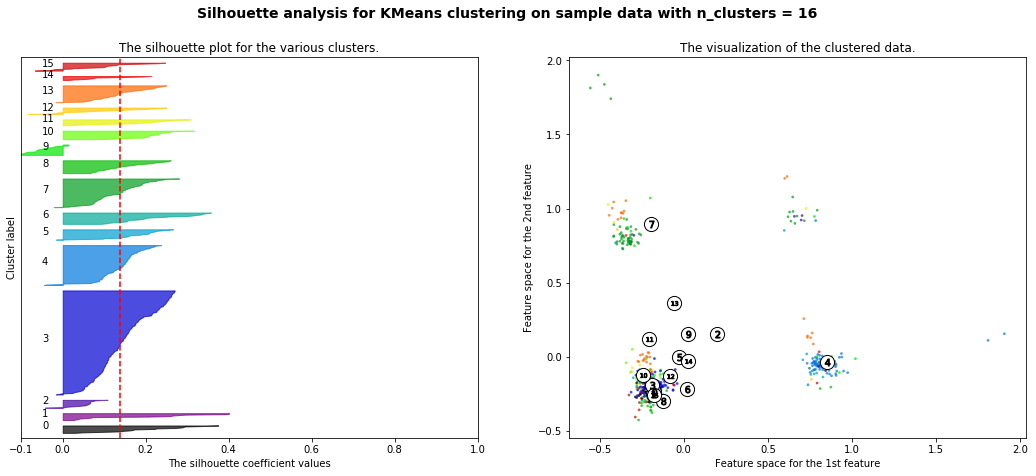

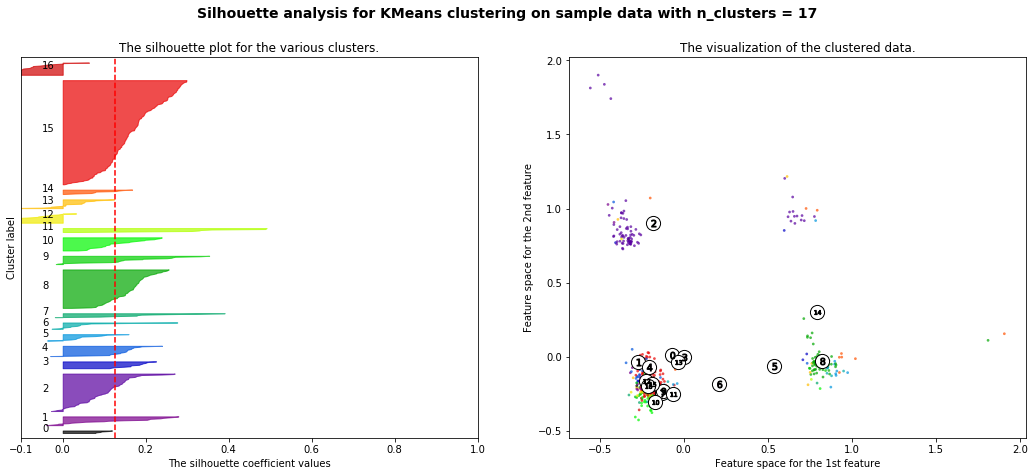

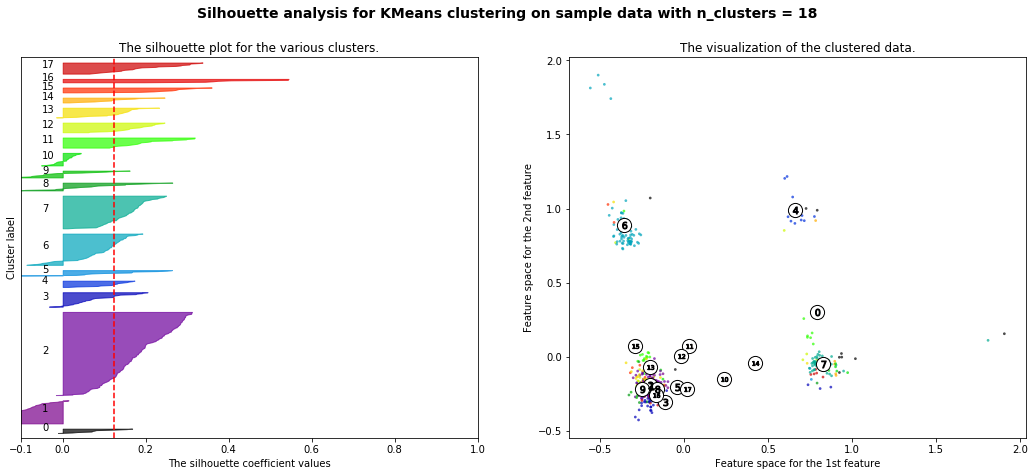

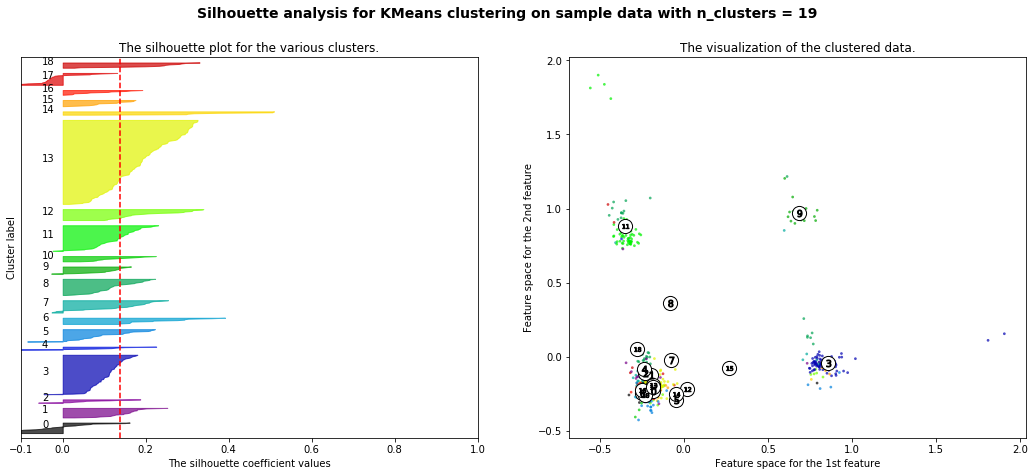

In [461]:
find_k(feature_array_title_pca)

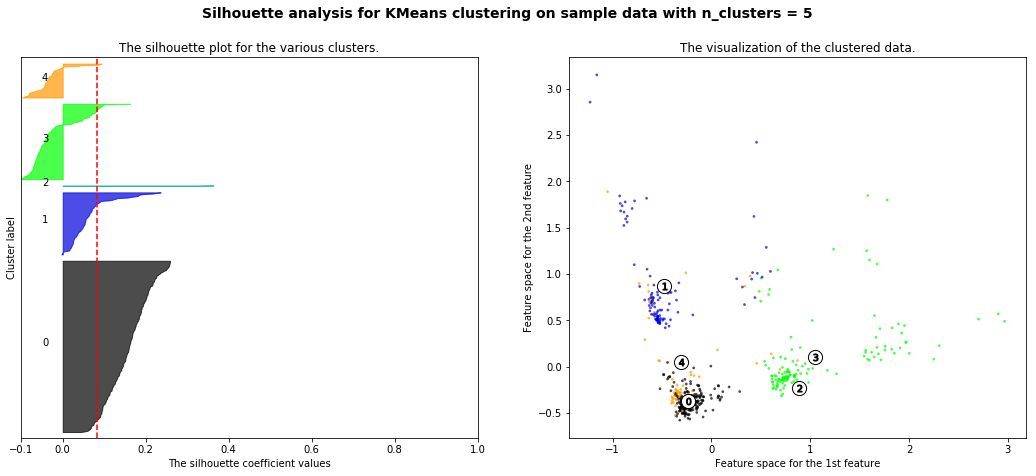

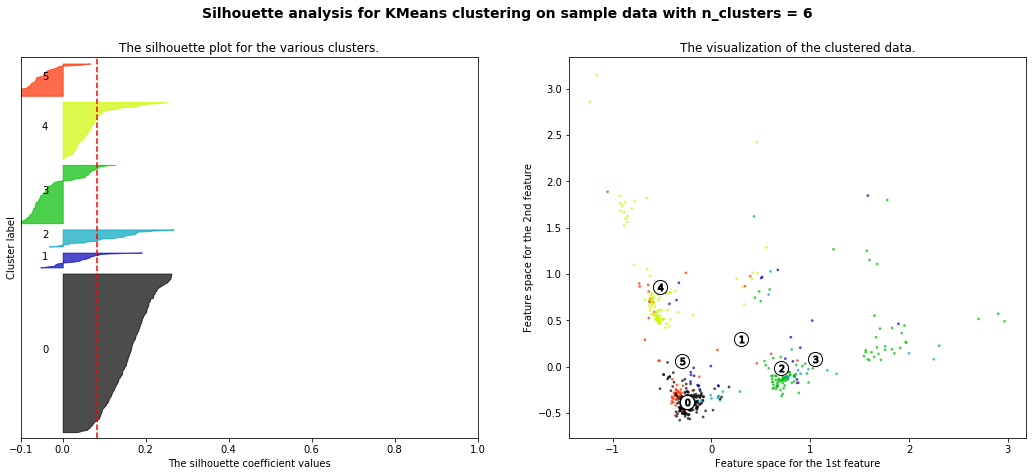

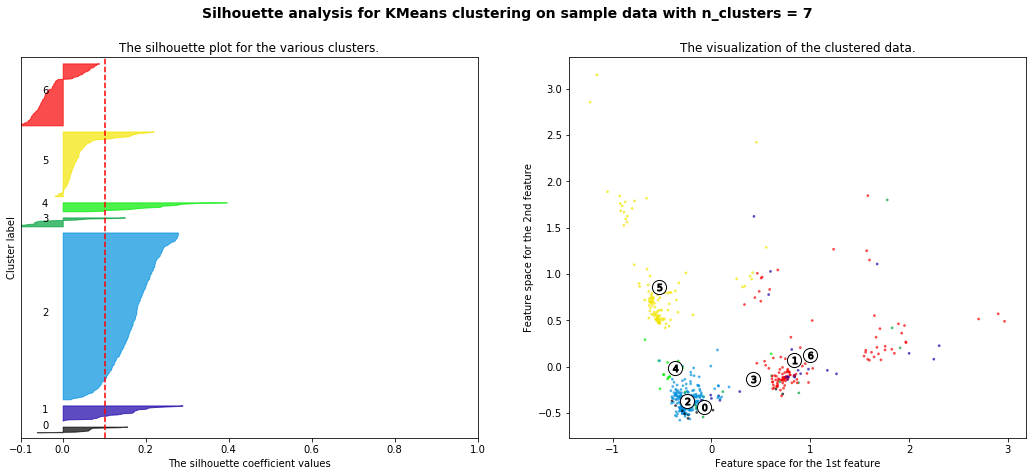

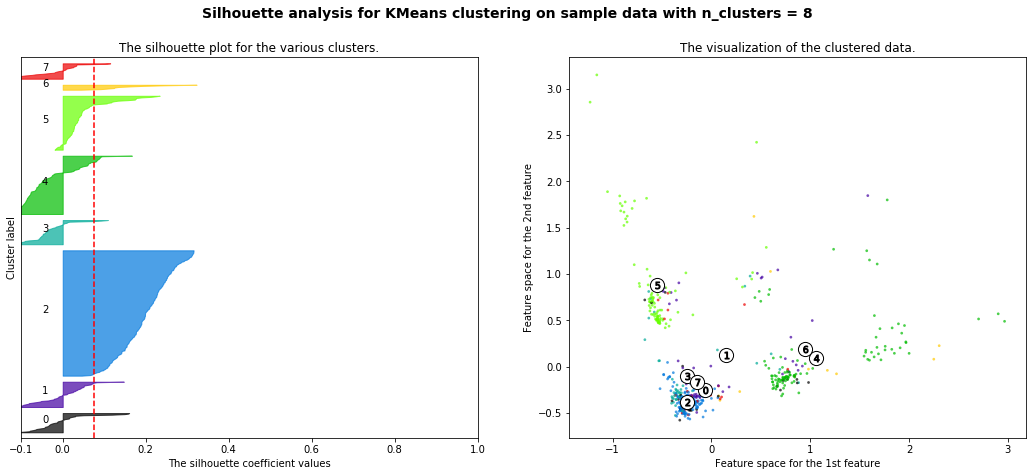

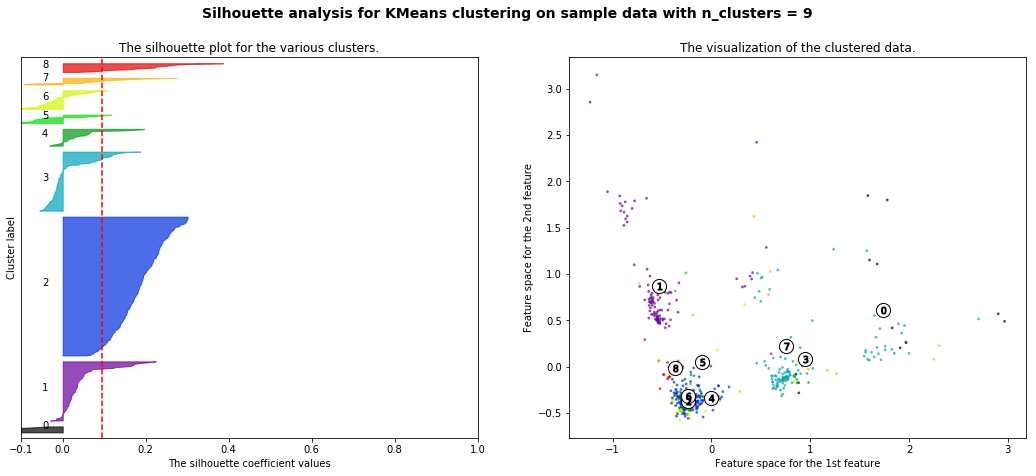

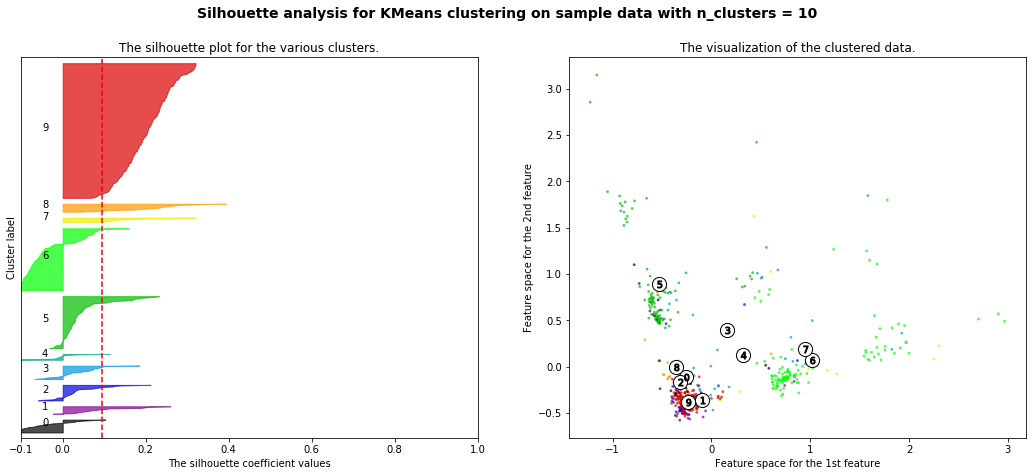

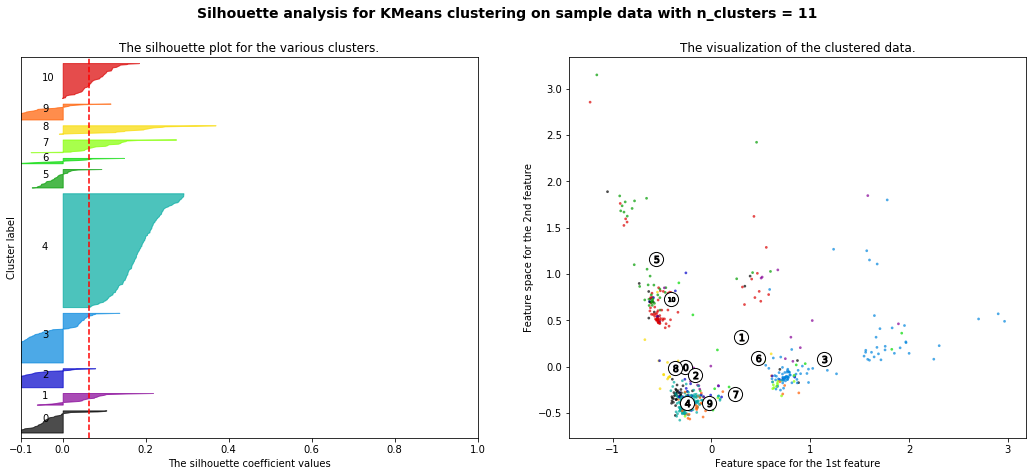

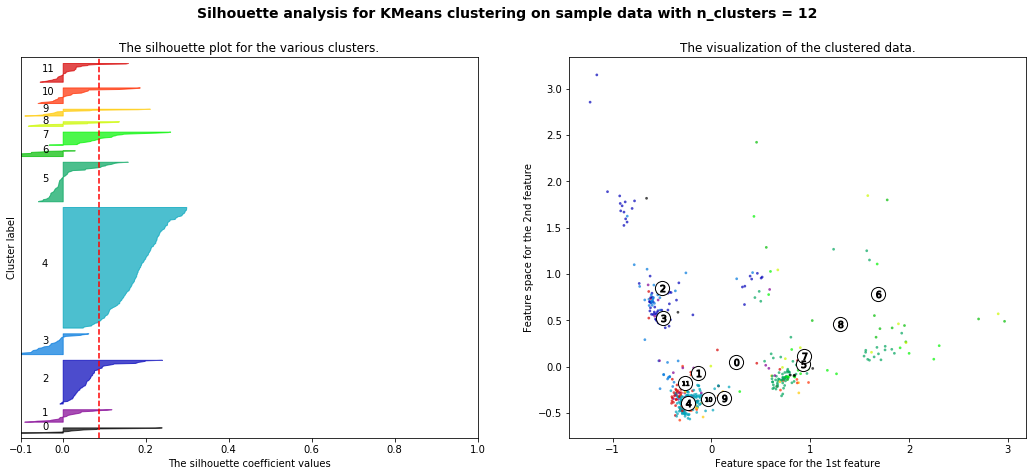

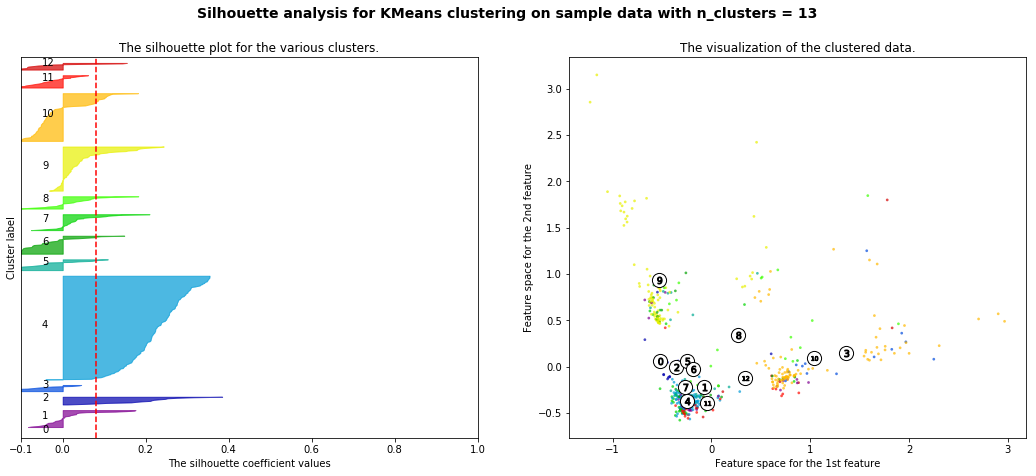

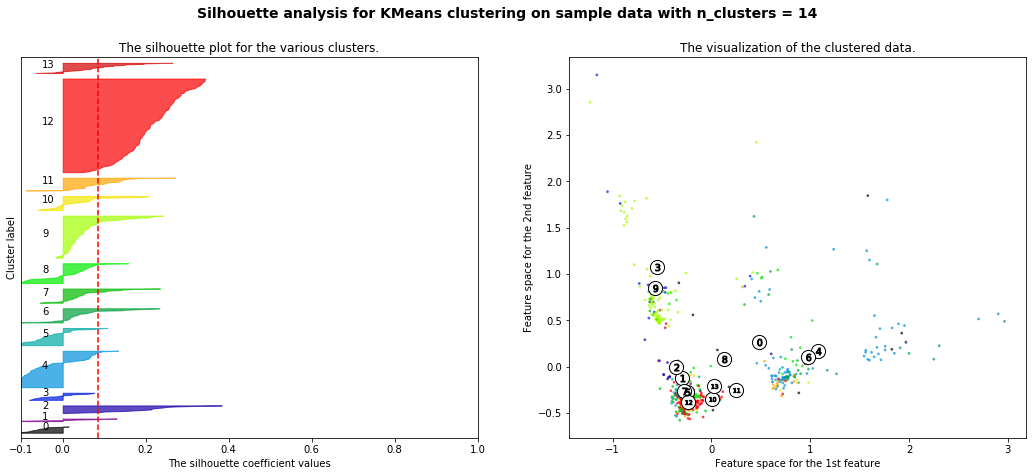

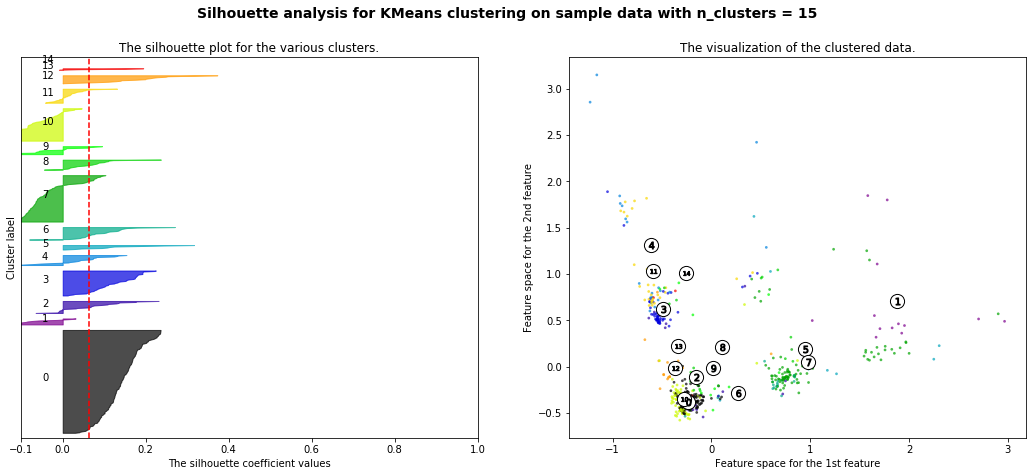

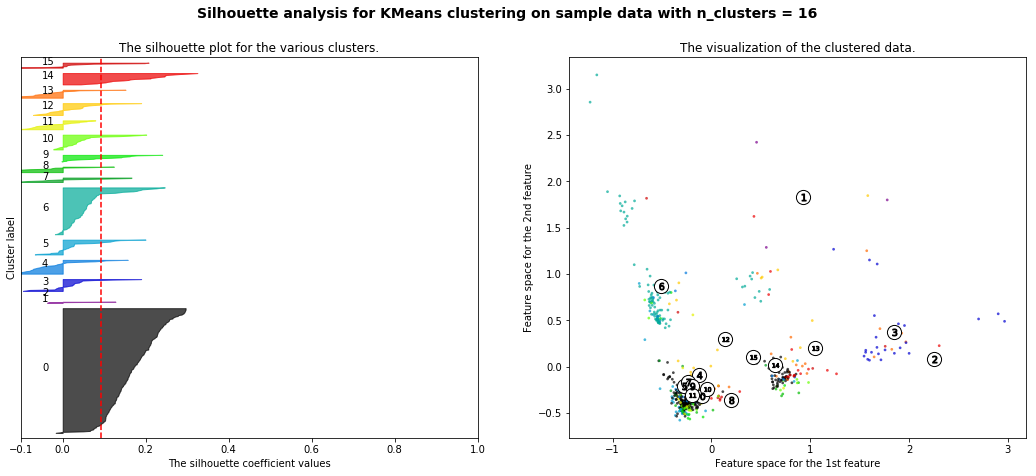

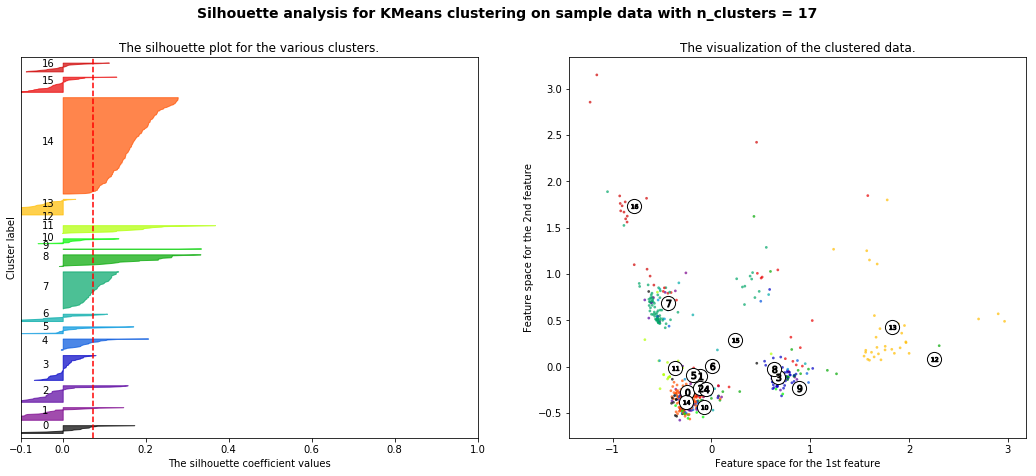

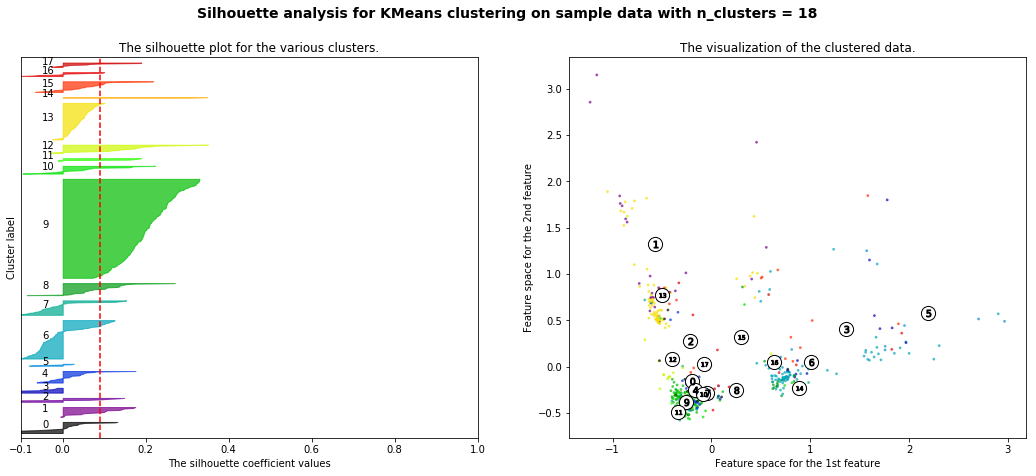

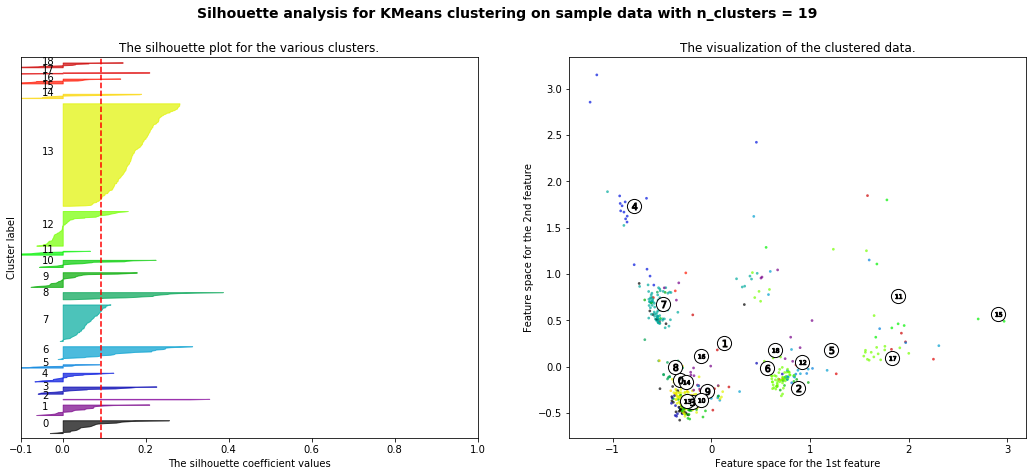

In [462]:
find_k(feature_array_index_pca)

## Results interpretation
Choose k=10 for title data. 

In [486]:
labels, centers = kmeans_cluster(feature_array_title_pca, 10)

In [496]:
title_collection =[list('s')]*10
    
for i in range(0,np.size(labels)):
     title_collection[labels[i]].append(titles[i])


In [505]:
for i in range(0, 602):
    if labels[i] == 3:
        print i,titles[i]

0 Structured Prediction via the Extragradient Method
1 Approximate Correspondences in High Dimensions
6 An Application of Markov Random Fields to Range Sensing
7 PAC-Bayes Bounds for the Risk of the Majority Vote and the Variance of the Gibbs Classifier
13 Efficient estimation of hidden state dynamics from spike trains
14 TrueSkill™: A Bayesian Skill Rating System
17 Top-Down Control of Visual Attention: A Rational Account
20 A Bayesian Spatial Scan Statistic
23 A Nonparametric Bayesian Method for Inferring Features From Similarity Judgments
24 Dynamical synapses give rise to a power-law distribution of neuronal avalanches
25 Recovery of Jointly Sparse Signals from Few Random Projections
26 Factorial Switching Kalman Filters for Condition Monitoring in Neonatal Intensive Care
27 Robust design of biological experiments
28 Sparse Representation for Signal Classification
29 On the Relation Between Low Density Separation, Spectral Clustering and Graph Cuts
31 Convex Repeated Games and Fenc